In [1]:
import time
startTime = time.time()

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext, SQLContext


In [9]:
conf=SparkConf()
conf.set("spark.executor.instances", "4")
conf.set("spark.driver.memory", "10g")

sc = SparkContext.getOrCreate(conf)

spark = SQLContext(sc)

In [7]:
df = spark.read.csv('minute_weather.csv',header=True,inferSchema=True)
df.show(5)

+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+
|rowID|   hpwren_timestamp|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|rain_accumulation|rain_duration|relative_humidity|
+-----+-------------------+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+
|    0|2011-09-10 00:00:49|       912.3|   64.76|              97.0|           1.2|             106.0|           1.6|              85.0|           1.0|             null|         null|             60.5|
|    1|2011-09-10 00:01:49|       912.3|   63.86|             161.0|           0.8|             215.0|           1.5|              43.0|           0.2|              0.0|          0.0|         

In [12]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [11]:
df_no_date_row = df.drop('hpwren_timestamp','rowID')
df_no_date_row.dtypes

[('air_pressure', 'double'),
 ('air_temp', 'double'),
 ('avg_wind_direction', 'double'),
 ('avg_wind_speed', 'double'),
 ('max_wind_direction', 'double'),
 ('max_wind_speed', 'double'),
 ('min_wind_direction', 'double'),
 ('min_wind_speed', 'double'),
 ('rain_accumulation', 'double'),
 ('rain_duration', 'double'),
 ('relative_humidity', 'double')]

In [12]:
print(df_no_date_row.count(),len(df_no_date_row.columns))

1587257 11


In [13]:
from pyspark.sql.functions import isnull, when, count

df_no_date_row.select([count(when(isnull(c), c)).alias(c) for c in df_no_date_row.columns]).show()

+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+
|air_pressure|air_temp|avg_wind_direction|avg_wind_speed|max_wind_direction|max_wind_speed|min_wind_direction|min_wind_speed|rain_accumulation|rain_duration|relative_humidity|
+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+
|           0|       0|               433|           433|               433|           433|               433|           433|                1|            1|                0|
+------------+--------+------------------+--------------+------------------+--------------+------------------+--------------+-----------------+-------------+-----------------+



In [14]:
# For now, drop null given that they're <0.1% of total data

df_no_date_row_no_null = df_no_date_row.dropna()

In [15]:
from pyspark.mllib.stat import Statistics
import pandas as pd

# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    # wrapper around
    # https://forums.databricks.com/questions/3092/how-to-calculate-correlation-matrix-with-all-colum.html
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method=method)
    corr_mat_df = pd.DataFrame(corr_mat,
                    columns=df.columns, 
                    index=df.columns)
    return corr_mat_df

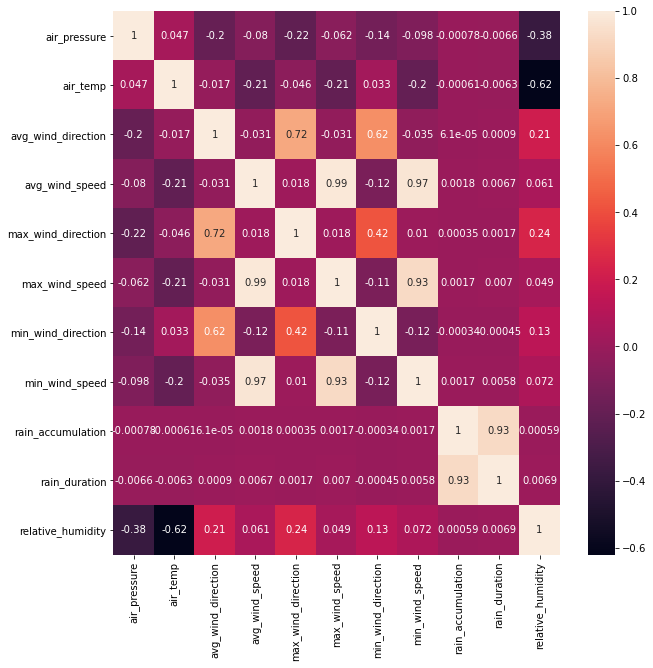

In [16]:
corrmat = compute_correlation_matrix(df_no_date_row_no_null, method='pearson')

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

sns.heatmap(corrmat,annot=True)

In [17]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.classification import GBTClassifier

gbtr = GBTRegressor(labelCol='relative_humidity')

## Regression

In [18]:
train,test = df_no_date_row_no_null.randomSplit([0.6,0.4])

In [19]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

paramGrid = ParamGridBuilder().addGrid(gbtr.maxDepth, [2, 10]).addGrid(gbtr.stepSize, [0.01, 0.1]).build()

rg = RegressionEvaluator(metricName="rmse", labelCol=gbtr.getLabelCol(), predictionCol=gbtr.getPredictionCol())
cv = CrossValidator(estimator=gbtr,evaluator=rg,numFolds=5,estimatorParamMaps=paramGrid)

In [20]:
from pyspark.ml.feature import VectorAssembler

features_input = (df_no_date_row_no_null.drop('relative_humidity')).columns

dassember = VectorAssembler(inputCols=features_input,outputCol='features')
df_feat = dassember.transform(df_no_date_row_no_null)

In [21]:
from pyspark.ml.pipeline import Pipeline

pl = Pipeline(stages=[dassember,cv])

In [22]:
Model = pl.fit(train)

In [23]:
Pred = Model.transform(test)
rg.evaluate(Pred)

14.507301182281964

In [24]:
df_no_date_row_no_null.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|summary|     air_pressure|          air_temp|avg_wind_direction|    avg_wind_speed|max_wind_direction|    max_wind_speed|min_wind_direction|    min_wind_speed|   rain_accumulation|     rain_duration| relative_humidity|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+
|  count|          1586823|           1586823|           1586823|           1586823|           1586823|           1586823|           1586823|           1586823|             1586823|           1586823|           1586823|
|   mean|916.8302481120576| 61.85526703356294| 161.9654202138487|2.7742730600703682|163.40308402386404| 3.39981453508034

In [25]:
trainPred = Model.transform(train)
rg.evaluate(trainPred)

14.282229559780072


## Classification

In [28]:
from pyspark.ml.feature import Binarizer
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

df_no_date_row_no_null = df_no_date_row_no_null.withColumn('relative_humidity',col('relative_humidity').cast(DoubleType()))

binr = Binarizer(threshold=47,inputCol='relative_humidity',outputCol='humclass')

In [29]:
df_no_date_row_no_null_binr = binr.transform(df_no_date_row_no_null)

train_class,test_class = df_no_date_row_no_null_binr.randomSplit([0.6,0.4])

In [30]:
from pyspark.ml.feature import VectorAssembler

features_input_class = (df_no_date_row_no_null_binr.drop('relative_humidity','humclass')).columns

dassember_class = VectorAssembler(inputCols=features_input_class,outputCol='features')
df_feat_class = dassember_class.transform(df_no_date_row_no_null_binr)

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator


gbtc = GBTClassifier(labelCol='humclass')


# rg = RegressionEvaluator(metricName="rmse", labelCol=gbtr.getLabelCol(), predictionCol=gbtr.getPredictionCol())

cl = BinaryClassificationEvaluator(labelCol=gbtc.getLabelCol())
cv_class = CrossValidator(estimator=gbtc,evaluator=cl,numFolds=5,estimatorParamMaps=paramGrid)

In [32]:
from pyspark.ml.pipeline import Pipeline
pl_class = Pipeline(stages=[dassember_class,cv_class])

Model_class = pl_class.fit(train_class)

In [33]:
Pred_class = Model_class.transform(test_class)
cl.evaluate(Pred_class)

0.8991164837617821

In [34]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 898.3959293365479
